# The relationship between the direction in which the ball is hit and the base that the batter reaches in the current round.

## Prepare

In [2]:
# Notice: Run the code with Python version 3.9.12

# Libraries

import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

# Data Import

# The ball table is generated by our own database, contain conlumns: playID	gameID	ballPositionX	ballPositionY	ballPositionZ	ballTimeStamp, and all the play must include
# the condition event_code = 4 which helps us to determine that the ball must be hit into play.

ball = pd.read_csv('player&ball_pos_analysis/ball_pos_analysis.csv')

# The player table is also generated by our own databse, including all the columns: playID, playPerGame, gameID, playerNum, posCode, posName, playerTimeStamp, fieldX, fieldY
player = pd.read_csv('player&ball_pos_analysis/player_pos_analysis.csv')

# The homerun table is also generated by our own databse with only one column: playID. These playIDs are all the plays with homerun result.
homerun = pd.read_csv('player&ball_pos_analysis/plays_with_home_run.csv')

In [3]:
# Data preprocessing

#print(ball.shape)
#print(player.shape)

# ball.sample(30)
#player.head(30)

# ball.isna().sum() # no missing values
# player.isna().sum() # no missing values

# Count the number of unique play IDs
# len(ball.playID.unique())



### Find the ball Direction

In [4]:
# Find the first two lines after the ball was hit

grouped = ball.groupby('playID').apply(lambda x: x.sort_values('ballTimeStamp')).reset_index(level=0, drop=True)

filtered_df = grouped.groupby('playID').apply(lambda x: x[x['ballPositionY'].diff() > 0].head(2))

filtered_df.reset_index(drop=True, inplace=True)

In [5]:

# Calculate the direction of the ball

angle_df = pd.DataFrame(columns=['playID', 'gameID', 'playPerGame', 'angle_deg'])

for playID, group in filtered_df.groupby('playID'):
    for i in range(0, len(group), 2):
        if i + 1 < len(group):
            gameID = group.iloc[i]['gameID']
            playPerGame = group.iloc[i]['playPerGame']
            
            x1 = group.iloc[i]['ballPositionX']
            y1 = group.iloc[i]['ballPositionY']
            x2 = group.iloc[i + 1]['ballPositionX']
            y2 = group.iloc[i + 1]['ballPositionY']
            
            angle_rad = np.arctan2(y2 - y1, x2 - x1)
            angle_deg = np.degrees(angle_rad)
            
            angle_df = angle_df.append({'playID': playID, 'gameID': gameID, 'playPerGame': playPerGame, 'angle_deg': angle_deg}, ignore_index=True)



/var/folders/_x/202cpd2n4c1_cwtp8thvbbzm0000gn/T/ipykernel_25850/634205142.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  angle_df = angle_df.append({'playID': playID, 'gameID': gameID, 'playPerGame': playPerGame, 'angle_deg': angle_deg}, ignore_index=True)
/var/folders/_x/202cpd2n4c1_cwtp8thvbbzm0000gn/T/ipykernel_25850/634205142.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  angle_df = angle_df.append({'playID': playID, 'gameID': gameID, 'playPerGame': playPerGame, 'angle_deg': angle_deg}, ignore_index=True)
/var/folders/_x/202cpd2n4c1_cwtp8thvbbzm0000gn/T/ipykernel_25850/634205142.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  angle_df = angle_df.append({'playID': playID, 'gameID': gameID, 'playPerGame'

In [6]:
# Change to the integers

angle_df['playID'] = angle_df['playID'].astype(int)
angle_df['gameID'] = angle_df['gameID'].astype(int)
angle_df['playPerGame'] = angle_df['playPerGame'].astype(int)

### Find the player position

In [7]:
sorted_df = player.groupby('gameID').apply(lambda x: x.sort_values(by=['playPerGame', 'playerTimeStamp'])).reset_index(drop=True)

In [8]:
# Build a new dataframe with every row contain the playID playPergame and gameID, also including a new feature
# "result" which have value 1, 2, 3 means batter run to first, second, third base.

# Used to save value
new_data = []

# find all the game id
unique_games = sorted_df['gameID'].unique()

for game_id in unique_games:
    game_data = sorted_df[sorted_df['gameID'] == game_id]
    
    # Now check details about each single game
    for i in range(len(game_data)):
        row = game_data.iloc[i]
        
        if row['posCode'] == 10:
            player_num = row['playerNum']
            play_per_game = row['playPerGame']
            next_play_per_game = play_per_game + 1
            
            next_row = game_data[(game_data['playPerGame'] == next_play_per_game) & 
                                 (game_data['playerNum'] == player_num) & 
                                 (game_data['posCode'].isin([11, 12, 13]))]
            
            if not next_row.empty:
                result = next_row['posCode'].values[0] - 10
                new_data.append((row['playID'], play_per_game, game_id, result))

# build new dataframe
new_columns = ['playID', 'playPerGame', 'gameID', 'result']
batter_df = pd.DataFrame(new_data, columns=new_columns)


## Topics

### 1. Is the probability of a batter reaching **first base** higher in the second quadrant than in the first quadrant when the ball is hit toward the second quadrant?

In [10]:
# Filter the rows
firstbase_df = batter_df[batter_df['result'] == 1]
firstbase_df = angle_df[angle_df['playID'].isin(firstbase_df['playID'].tolist())]

In [11]:
# Calculate the average, median, mode angle
firstbase_avg = statistics.mean(firstbase_df['angle_deg'])

firstbase_median = statistics.median(firstbase_df['angle_deg'])

firstbase_mode = statistics.mode(firstbase_df['angle_deg'])

firstbase_avg, firstbase_median, firstbase_mode

(90.33035475180996, 90.67952288308788, 118.82503424845963)

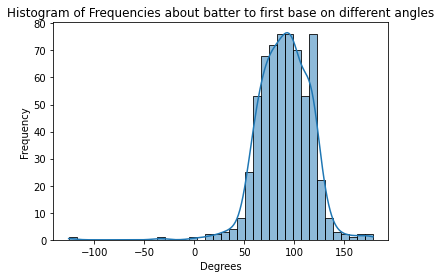

In [12]:
sns.histplot(firstbase_df['angle_deg'], kde=True)
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Histogram of Frequencies about batter to first base on different angles')
plt.show()

/var/folders/_x/202cpd2n4c1_cwtp8thvbbzm0000gn/T/ipykernel_25850/3006999010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstbase_df['quadrant'] = firstbase_df['angle_deg'].apply(lambda x: 'first quadrant' if x < 90 else 'second quadrant')


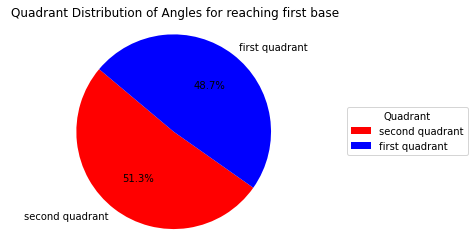

In [13]:
# Pie Chart
firstbase_df['quadrant'] = firstbase_df['angle_deg'].apply(lambda x: 'first quadrant' if x < 90 else 'second quadrant')

quadrant_counts = firstbase_df['quadrant'].value_counts()

colors = ['red', 'blue']

plt.pie(quadrant_counts, labels=quadrant_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'color': 'black'})

plt.title('Quadrant Distribution of Angles for reaching first base', color='black')

plt.legend(title='Quadrant', labels=quadrant_counts.index, loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis('equal')
plt.show()

### 2. Is the probability of a batter reaching **second base** higher in the second quadrant than in the first quadrant when the ball is hit toward the second quadrant?

In [14]:
# Filter the rows
secondbase_df = batter_df[batter_df['result'] == 2]
secondbase_df = angle_df[angle_df['playID'].isin(secondbase_df['playID'].tolist())]

In [15]:
# Calculate the average, median, mode angle
secondbase_avg = statistics.mean(secondbase_df['angle_deg'])

secondbase_median = statistics.median(secondbase_df['angle_deg'])

secondbase_mode = statistics.mode(secondbase_df['angle_deg'])

secondbase_avg, secondbase_median, secondbase_mode

(95.44066935257405, 96.3464715920391, 102.37709126613552)

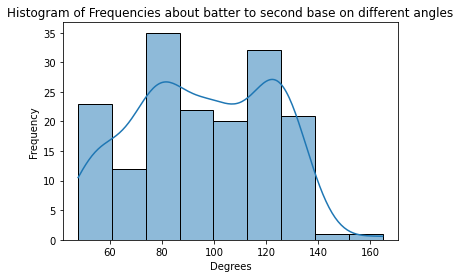

In [16]:
sns.histplot(secondbase_df['angle_deg'], kde=True)
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Histogram of Frequencies about batter to second base on different angles')
plt.show()

/var/folders/_x/202cpd2n4c1_cwtp8thvbbzm0000gn/T/ipykernel_25850/3391766602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondbase_df['quadrant'] = secondbase_df['angle_deg'].apply(lambda x: 'first quadrant' if x < 90 else 'second quadrant')


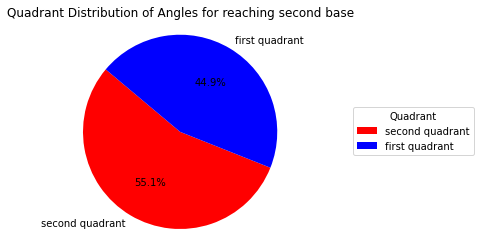

In [17]:
# Pie Chart
secondbase_df['quadrant'] = secondbase_df['angle_deg'].apply(lambda x: 'first quadrant' if x < 90 else 'second quadrant')

quadrant_counts = secondbase_df['quadrant'].value_counts()

colors = ['red', 'blue']

plt.pie(quadrant_counts, labels=quadrant_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'color': 'black'})

plt.title('Quadrant Distribution of Angles for reaching second base', color='black')

plt.legend(title='Quadrant', labels=quadrant_counts.index, loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis('equal')
plt.show()

### 3. Is the probability of a batter reaching **third base** higher in the second quadrant than in the first quadrant when the ball is hit toward the second quadrant?

In [18]:
# Filter the rows
thirdbase_df = batter_df[batter_df['result'] == 3]
thirdbase_df = angle_df[angle_df['playID'].isin(thirdbase_df['playID'].tolist())]

In [19]:
# Calculate the average, median, mode angle
thirdbase_avg = statistics.mean(thirdbase_df['angle_deg'])

thirdbase_median = statistics.median(thirdbase_df['angle_deg'])

thirdbase_mode = statistics.mode(thirdbase_df['angle_deg'])

thirdbase_avg, thirdbase_median, thirdbase_mode

(81.542293461749, 79.1220513051903, 72.93575110395545)

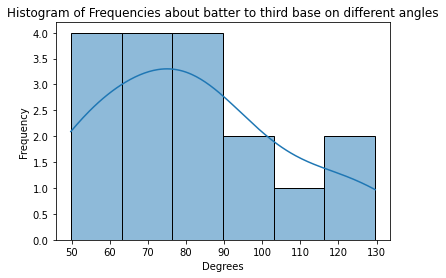

In [20]:
sns.histplot(thirdbase_df['angle_deg'], kde=True)
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Histogram of Frequencies about batter to third base on different angles')
plt.show()

/var/folders/_x/202cpd2n4c1_cwtp8thvbbzm0000gn/T/ipykernel_25850/244387918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thirdbase_df['quadrant'] = thirdbase_df['angle_deg'].apply(lambda x: 'first quadrant' if x < 90 else 'second quadrant')


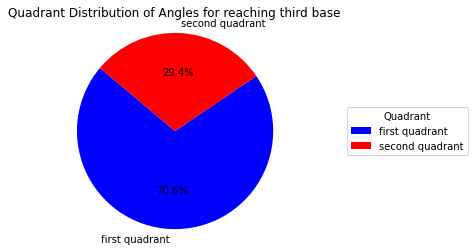

In [21]:
# Pie Chart
thirdbase_df['quadrant'] = thirdbase_df['angle_deg'].apply(lambda x: 'first quadrant' if x < 90 else 'second quadrant')

quadrant_counts = thirdbase_df['quadrant'].value_counts()

colors = ['blue', 'red']

plt.pie(quadrant_counts, labels=quadrant_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'color': 'black'})

plt.title('Quadrant Distribution of Angles for reaching third base', color='black')

plt.legend(title='Quadrant', labels=quadrant_counts.index, loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis('equal')
plt.show()

### 4. Is the probability of a batter do **homerun** higher in the second quadrant than in the first quadrant when the ball is hit toward the second quadrant?

In [22]:
# Filter the rows
homerun_df = angle_df[angle_df['playID'].isin(homerun['playID'].tolist())]

In [23]:
# Calculate the average, median, mode angle
homerun_avg = statistics.mean(homerun_df['angle_deg'])

homerun_median = statistics.median(homerun_df['angle_deg'])

homerun_mode = statistics.mode(homerun_df['angle_deg'])

homerun_avg, homerun_median, homerun_mode

(95.12815856191757, 103.47434435270941, 115.43711270672009)

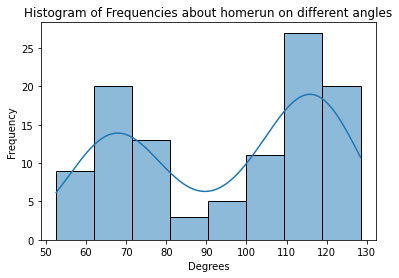

In [24]:
sns.histplot(homerun_df['angle_deg'], kde=True)
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Histogram of Frequencies about homerun on different angles')
plt.show()

/var/folders/_x/202cpd2n4c1_cwtp8thvbbzm0000gn/T/ipykernel_25850/2203505686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homerun_df['quadrant'] = homerun_df['angle_deg'].apply(lambda x: 'first quadrant' if x < 90 else 'second quadrant')


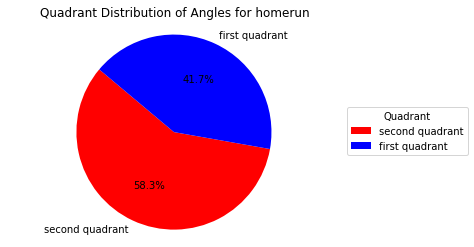

In [25]:
# Pie Chart
homerun_df['quadrant'] = homerun_df['angle_deg'].apply(lambda x: 'first quadrant' if x < 90 else 'second quadrant')

quadrant_counts = homerun_df['quadrant'].value_counts()

colors = ['red', 'blue']

plt.pie(quadrant_counts, labels=quadrant_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'color': 'black'})

plt.title('Quadrant Distribution of Angles for homerun', color='black')

plt.legend(title='Quadrant', labels=quadrant_counts.index, loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis('equal')
plt.show()

### 5. How about in total?

In [26]:
# Filter the rows
total_df = angle_df[angle_df['playID'].isin(batter_df['playID'].tolist())]

In [27]:
# Calculate the average, median, mode angle
total_avg = statistics.mean(total_df['angle_deg'])

total_median = statistics.median(total_df['angle_deg'])

total_mode = statistics.mode(total_df['angle_deg'])

total_avg, total_median, total_mode

(91.19418971671372, 91.40518770899088, 118.82503424845963)

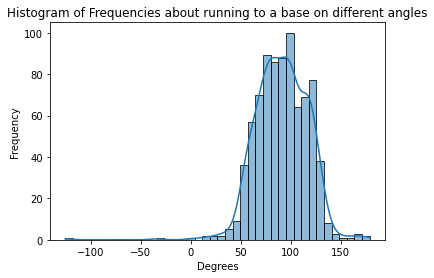

In [28]:
sns.histplot(total_df['angle_deg'], kde=True)
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Histogram of Frequencies about running to a base on different angles')
plt.show()

/var/folders/_x/202cpd2n4c1_cwtp8thvbbzm0000gn/T/ipykernel_25850/3570412057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['quadrant'] = total_df['angle_deg'].apply(lambda x: 'first quadrant' if x < 90 else 'second quadrant')


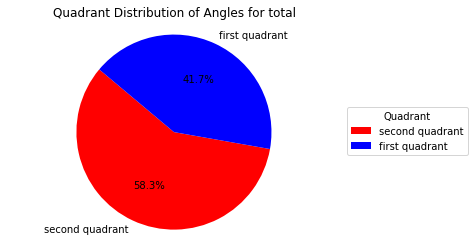

In [29]:
# Pie Chart
total_df['quadrant'] = total_df['angle_deg'].apply(lambda x: 'first quadrant' if x < 90 else 'second quadrant')

total_counts = total_df['quadrant'].value_counts()

colors = ['red', 'blue']

plt.pie(quadrant_counts, labels=quadrant_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'color': 'black'})

plt.title('Quadrant Distribution of Angles for total', color='black')

plt.legend(title='Quadrant', labels=quadrant_counts.index, loc='center left', bbox_to_anchor=(1, 0.5))

plt.axis('equal')
plt.show()